In [46]:
import os, random, math

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import lightgbm as lgb

import librosa
import librosa.display

from scipy.stats import skew, kurtosis
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from prettytable import PrettyTable
from tqdm import tqdm_notebook, tqdm_pandas
tqdm_notebook().pandas(smoothing=0.7)

import IPython
import IPython.display as ipd

import matplotlib as mpl
mpl.rcParams['font.size'] = 14

HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

In [48]:
def preds_to_labels(p, labels):
    predictions = [list(np.argsort(p[i])[::-1][:3]) for i in range(len(p))]
    prediction_labels = []
    
    for pred in predictions:
        label_list = []
        for output in pred:
            label_list.append(labels[output])
        prediction_labels.append(label_list)
    return prediction_labels

In [49]:
import soundfile as sf
def spectral_features(fname=None, root=None, n_mfcc=15, return_fnames=False):
    feature_names = []
    for i in ['mean', 'std', 'min', 'max', 'skew', 'kurt']:
        for j in range(n_mfcc):
            feature_names.append('mfcc_{}_{}'.format(j, i))
        feature_names.append('centroid_{}'.format(i))
        feature_names.append('bandwidth_{}'.format(i))
        feature_names.append('contrast_{}'.format(i))
        feature_names.append('rolloff_{}'.format(i))
        feature_names.append('flatness_{}'.format(i))
        feature_names.append('zcr_{}'.format(i))
    
    if return_fnames:
        return feature_names

    spectral_features = [
        librosa.feature.spectral_centroid,
        librosa.feature.spectral_bandwidth,
        librosa.feature.spectral_contrast,
        librosa.feature.spectral_rolloff,
        librosa.feature.spectral_flatness,
        librosa.feature.zero_crossing_rate]
     
    try:
##        data, fs = librosa.core.load(root + fname, sr=None)
        data, fs = sf.read(root + fname)
        M = librosa.feature.mfcc(data, sr=fs, n_mfcc=n_mfcc)
        data_row = np.hstack((np.mean(M, axis=1), np.std(M, axis=1), np.min(M, axis=1),
                              np.max(M, axis=1), skew(M, axis=1), kurtosis(M, axis=1)))
        
        for feat in spectral_features:
            S = feat(data)[0]
            data_row = np.hstack((data_row, np.mean(S), np.std(S), np.min(S),
                                  np.max(S), skew(S), kurtosis(S)))

        return pd.Series(data_row)
        
    except (ValueError, RuntimeError):
        print("Bad file at {}".format(fname))
        return pd.Series([0]*len(feature_names))  

In [50]:
def create_submission(predictions, name='submission.csv'):
    predictions = ['{} {} {}'.format(x[0], x[1], x[2]) for x in predictions]
    submission = pd.read_csv('input/sample_submission.csv')
    submission.label = predictions
    submission.to_csv('{}'.format(name), index=False)
    print("Submission saved to '{}'".format(name))


In [51]:
def data_split(train_df, test_df, shuffle=True, test_size=0.25, random_state=0, verbose=True):
    # Get numpy array of X data
    X_train = train_df.drop(['fname', 'label', 'manually_verified'], axis=1).values
    X_test = test_df.drop(['fname', 'label'], axis=1).values
    feature_names = list(test_df.drop(['fname', 'label'], axis=1).columns.values)

    # Get numpy array of y data
    y_train = pd.get_dummies(train_df.label)
    labels = y_train.columns.values
    y_train = y_train.values

    y_train = [np.argmax(row) for row in y_train]
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=test_size,
                                                          random_state=random_state, shuffle=shuffle)
    if verbose:
        print("Train X shape = {}\nTrain y shape = {}".format(X_train.shape, len(y_train)))
        print("\nValid X shape = {}\nValid y shape = {}".format(X_valid.shape, len(y_valid)))

    assert X_train.shape[1] == X_valid.shape[1] == X_test.shape[1]
    assert len(y_train) == X_train.shape[0]
    assert len(y_valid) == X_valid.shape[0]
    
    return X_train, X_valid, y_train, y_valid, X_test, feature_names, labels



In [52]:
def trim_silence(fname, root, window_length=0.5):
    try:
        trimmed_ends = 0
        trimmed_int = 0
        
        data, fs = librosa.core.load(root + fname, sr=None)
        length = len(data)
        
        # Trim silence from ends
        data, _ = librosa.effects.trim(data, top_db=40)
        length_int = len(data)
        ratio_int = length_int/length
        
        # Split file into non-silent chunks and recombine
        splits = librosa.effects.split(data, top_db=40)
        if len(splits) > 1:
            data = np.concatenate([data[x[0]:x[1]] for x in splits])    
        
        length_final = len(data)
        ratio_final = length_final/length_int     

        if cache:
            # Save file and return new features
            librosa.output.write_wav('{}_trimmed/{}'.format(root[:-1], fname), data, fs)
        return pd.Series([length_int, length_final, ratio_int, ratio_final])
       
    except ValueError:
        print("Bad file at {}".format(fname))
        return pd.Series([0, 0, 0, 0])  



In [53]:
def apk(actual, predicted, k=10):
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)

def mapk(actual, predicted, k=10):
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])


In [54]:
train_df = pd.read_csv('cache/train_spectral.csv')
test_df = pd.read_csv('cache/test_spectral.csv')
assert len(train_df.index) == n_training
assert len(test_df.index) == n_test
print("Files loaded from cache")



Files loaded from cache


In [55]:
import multiprocessing
def lgb_dset(X_train, X_valid, y_train, y_valid, feature_names):
    
    d_train = lgb.Dataset(X_train, label=y_train, feature_name=feature_names)
    d_valid = lgb.Dataset(X_valid, label=y_valid, feature_name=feature_names)

    params = {
        'boosting_type': 'gbdt',
        'objective': 'multiclass',
        'metric': 'multi_logloss',
        'max_depth': 4,
        'num_leaves': 20,
        'learning_rate': 0.025,
        'feature_fraction': 0.65,
        'bagging_fraction': 0.65,
        'bagging_freq': 5,
        'num_threads': multiprocessing.cpu_count(),
        'lambda_l2': 1.0,
        'min_gain_to_split': 0,
        'num_class': n_categories,
    }
    
    return d_train, d_valid, params


In [25]:
# Create dataset
X_train, X_valid, y_train, y_valid, X_test, feature_names, labels = data_split(train_df,
                                                                               test_df,test_size = 0)
#print(y_train)
d_train, d_valid, params = lgb_dset(X_train, X_valid, y_train, y_valid, feature_names)

# Train and predict
hist = clf = lgb.cv(params, d_train, num_boost_round=2000,  verbose_eval=200, early_stopping_rounds=100)


Train X shape = (9473, 170)
Train y shape = 9473

Valid X shape = (0, 170)
Valid y shape = 0
[200]	cv_agg's multi_logloss: 1.32954 + 0.0242852
[400]	cv_agg's multi_logloss: 1.1125 + 0.0281293
[600]	cv_agg's multi_logloss: 1.03803 + 0.0325897
[800]	cv_agg's multi_logloss: 1.00738 + 0.0357591
[1000]	cv_agg's multi_logloss: 0.992943 + 0.0383877
[1200]	cv_agg's multi_logloss: 0.98604 + 0.0400202
[1400]	cv_agg's multi_logloss: 0.983975 + 0.0420138
[1600]	cv_agg's multi_logloss: 0.983358 + 0.0435548


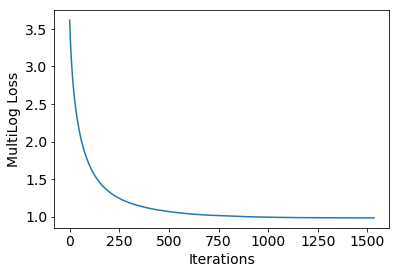

In [56]:
plt.xlabel('Iterations')
plt.ylabel('MultiLog Loss')
plt.plot(range(1534),hist.values()[0])

In [20]:
# Create dataset
X_train, X_valid, y_train, y_valid, X_test, feature_names, labels = data_split(train_df, test_df, verbose=False)
#print(y_train)
d_train, d_valid, params = lgb_dset(X_train, X_valid, y_train, y_valid, feature_names)

# Train and predict
clf = lgb.train(params, d_train, num_boost_round=2000, valid_sets=d_valid, verbose_eval=200, early_stopping_rounds=100)
p = clf.predict(X_valid, num_iteration=clf.best_iteration)

# Score
predictions = [list(np.argsort(p[i])[::-1][:3]) for i in range(len(p))]
actual = [[i] for i in y_valid]
valid_score = mapk(actual, predictions, k=3)
print("\nScore = {:.4f}".format(valid_score))



Training until validation scores don't improve for 100 rounds.
[200]	valid_0's multi_logloss: 1.37055
[400]	valid_0's multi_logloss: 1.15398
[600]	valid_0's multi_logloss: 1.08669
[800]	valid_0's multi_logloss: 1.05531
[1000]	valid_0's multi_logloss: 1.04097
[1200]	valid_0's multi_logloss: 1.03327
[1400]	valid_0's multi_logloss: 1.02979
[1600]	valid_0's multi_logloss: 1.02903
[1800]	valid_0's multi_logloss: 1.02901
Early stopping, best iteration is:
[1735]	valid_0's multi_logloss: 1.02847

Score = 0.7883


In [22]:
# CV = 0.7854, LB = 0.835
p = clf.predict(X_test, num_iteration=clf.best_iteration)
np.save('submission-{:.4f}.npy'.format(valid_score),p)
lab = preds_to_labels(p, labels)
create_submission(lab, 'submission-{:.4f}.csv'.format(valid_score))

Submission saved to 'submission-0.7883.csv'


In [27]:
# Create dataset
X_train, X_valid, y_train, y_valid, X_test, feature_names, labels = \
    data_split(train_df, test_df, test_size=0)
d_train = lgb.Dataset(X_train, label=y_train, feature_name=feature_names)


Train X shape = (9473, 170)
Train y shape = 9473

Valid X shape = (0, 170)
Valid y shape = 0


In [28]:
# Train and predict
print("Begin training...")
clf = lgb.train(params, d_train, num_boost_round=2000)

print("Begin test predictions...")
p = clf.predict(X_test)


Begin training...
Begin test predictions...


In [32]:
lab = preds_to_labels(p, labels)

create_submission(lab, 'submission-test_kitchen7898.csv')
print("Submission created.")

Submission saved to 'submission-test_kitchen7898.csv'
Submission created.
